Adapted from: niuers. (n.d.). *Learning-From-Data-A-Short-Course* [GitHub repository]. GitHub. https://github.com/niuers/Learning-From-Data-A-Short-Course


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

#target = -1 + 2*x1 + 2*x2 #np.array([2,2,-1])
df = pd.DataFrame({'x1':[0,1,0,-0.5,-1,2,1,3,0.5,-1,0,-2,-3,1,2,-4,-3,3,-0.5,-2],
                   'x2':[0,1,1,0,-1,4,-1,-5,-2,1,3,0,-1,6,8,2,3,10,2,1],
                   'y':[1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]})
df['x0'] = 1
df = df[['x0','x1', 'x2', 'y']]

def perceptron(points, dim, max_it=100, use_adaline=False, eta = 1, randomize=False, print_out = True):
    w = np.zeros(dim+1)
    xs, ys = points[:,:dim+1], points[:,dim+1]
    num_points = points.shape[0]
    for it in range(max_it):
        correctly_predicted_ids=  set()
        idxs = np.arange(num_points)
        if randomize:
            idxs = np.random.choice(np.arange(num_points), num_points, replace=False)
        for idx in idxs:
            x, y = xs[idx], ys[idx]
            st = np.dot(w.T, x)
            prod = st*y #np.dot(w.T, x)*y
            if prod < -100: #avoid out of bound error
                st = -100
            threshold = 1 if use_adaline else 0
            st = st if use_adaline else 0
            if prod <= threshold:
                w = w + eta *(y-st)*x
                break #PLA picks one example at each iteration
            else:
                correctly_predicted_ids.add(idx)
        if len(correctly_predicted_ids) == num_points:
            break

    c = 0
    for x, y in zip(xs, ys):
        prod = np.dot(w.T, x)*y
        if prod > 0:
            c +=1
    w = w/w[-1]
    if print_out:
        print('final correctness: ', c, '. Total iteration: ', it)
        print('final normalized w:', w)
    return w, it

def perceptron_raw(points, dim, max_it=1000, eta=1, randomize=False):
    w = np.zeros(dim+1)
    xs, ys = points[:,:dim+1], points[:,dim+1]
    num_points = points.shape[0]
    for it in range(max_it):
        correctly_predicted_ids=  set()
        idxs = np.arange(num_points)
        if randomize:
            idxs = np.random.choice(np.arange(num_points), num_points, replace=False)
        for idx in idxs:
            x, y = xs[idx], ys[idx]
            st = np.dot(w.T, x)
            prod = st*y #np.dot(w.T, x)*y
            if prod < -100: #avoid out of bound error
                st = -100
            threshold = 0
            st = 0
            if prod <= threshold:
                w = w + eta *(y-st)*x
                break #PLA picks one example at each iteration
            else:
                correctly_predicted_ids.add(idx)
        if len(correctly_predicted_ids) == num_points:
            break

    c = 0
    for x, y in zip(xs, ys):
        prod = np.dot(w.T, x)*y
        if prod > 0:
            c +=1

    return w, it


# what points, dim, max_it, eta, randomize do

In [ ]:
def run_perceptron_experiment(N, dim, lb, ub, num_grid_points, coeff_lb, coeff_ub,
                              eta, maxit, use_adaline=False, randomize=False,
                              show_plot=True, test_N = 10000):

    rns = generate_random_numbers(N, dim, num_grid_points, lb, ub)
    rn_func = lambda N, dim: generate_random_numbers(N, dim, num_grid_points, lb, ub)
    coeffs = generate_random_numbers(1, dim+1, num_grid_points, coeff_lb, coeff_ub)
    norm_coeffs = coeffs.flatten()/coeffs.flatten()[-1]
    true_func = lambda x: true_f(x, coeffs=norm_coeffs)

    df = generate_df(N, dim, true_func, rn_func)
    test_df = generate_df(test_N, dim, true_func, rn_func)

    x1 = np.arange(lb, ub, 0.01)
    norm_g, num_its = perceptron(df.values, dim, maxit, use_adaline,
                                 eta, randomize, show_plot)

    if show_plot:
        print('True coeffs: ', norm_coeffs)
        plot_data(x1, df, norm_coeffs, norm_g, lb, ub)
    return num_its, norm_g, test_df

In [2]:
def generate_random_numbers01(N, dim, num_grid_points):
    random_ints = np.random.randint(num_grid_points, size=(N, dim))
    init_lb = 0
    return (random_ints - init_lb)/(num_grid_points - 1 - init_lb)


def generate_random_numbers(N, dim, num_grid_points, lb, ub):
    zero_to_one_points = generate_random_numbers01(N, dim, num_grid_points)
    res = lb + (ub - lb)*zero_to_one_points
    return res


def true_f(x, coeffs):
    return coeffs.flatten()[0] + np.dot(coeffs.flatten()[1:], x.flatten())



def generate_df(N, dim,true_func, rn_func):
    cls1, cls2 = generate_two_classes(N/2, dim, true_func, rn_func)
    cols = ['x' + str(i) for i in range(1, dim+1)]
    df1 = pd.DataFrame(cls1, columns=cols)
    df1['y'] = 1
    df2 = pd.DataFrame(cls2, columns=cols)
    df2['y'] = -1
    df = pd.concat([df1, df2])
    df['x0'] = 1
    df = df[['x0'] + cols + ['y']]
    return df


def generate_two_classes(N, dim, true_func, rn_func):
    cls1, cls2 = [], []
    while True:
        rn = rn_func(1, dim).flatten()
        if true_func(rn) > 0 and len(cls1) < N:
            cls1.append(rn)
        elif true_func(rn) < 0 and len(cls2) < N:
            cls2.append(rn)
        if len(cls1) == N and len(cls2) == N:
            break
    return np.asarray(cls1), np.asarray(cls2)

In [ ]:
def plot_data(x1, df, norm_coeffs, norm_g, lb, ub):
        figsize = plt.figaspect(1)
        f, ax = plt.subplots(1, 1, figsize=figsize)
        cls1_df = df.loc[df['y']==1]
        cls2_df = df.loc[df['y']==-1]
        line = ax.plot(x1, -(norm_coeffs[0]+norm_coeffs[1]*x1), label='True Function')
        pluses = ax.scatter(cls1_df[['x1']].values, cls1_df[['x2']].values, marker='+', c= 'r', label='+1 labels')
        minuses = ax.scatter(cls2_df[['x1']].values, cls2_df[['x2']].values, marker=r'$-$', c= 'b', label='-1 labels')
        if norm_g is not None:
            hypothesis = ax.plot(x1, -(norm_g[0]+norm_g[1]*x1), c = 'r', label='Final Hypothesis')

        ax.set_ylabel(r"$x_2$", fontsize=11)
        ax.set_xlabel(r"$x_1$", fontsize=11)
        ax.set_title('Data set size = %s'%N, fontsize=9)
        ax.axis('tight')
        legend_x = 1.5
        legend_y = 0.5
        ax.legend(['True Function',
                   '+1 labels', '-1 labels', 'Final Hypothesis'],
                  loc='center right', bbox_to_anchor=(legend_x, legend_y))
        #ax.legend(handles=[pluses, minuses], fontsize=9)
        ax.set_ylim(bottom=lb, top=ub)
        plt.show()

final correctness:  20 . Total iteration:  1
final normalized w: [-0.21967033 15.83516484  1.        ]
True coeffs:  [-2.8615917  -4.25259516  1.        ]


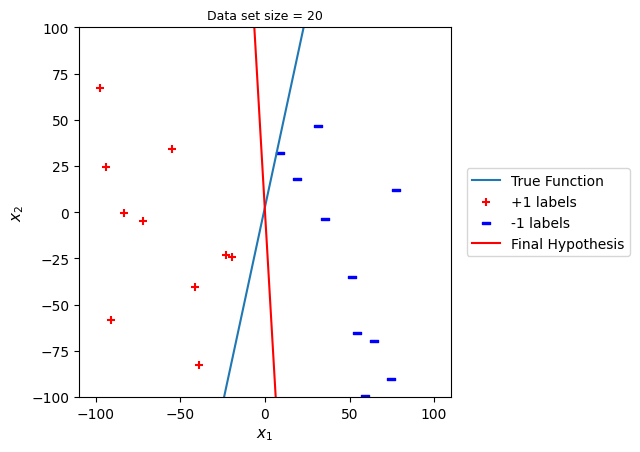

In [ ]:
#perceptron(df.values, 2)

lb, ub = -100, 100
N, dim = 20, 2
num_grid_points = 2000
coeff_lb, coeff_ub = -10, 10
eta = 1
maxit = 100
use_adaline, randomize = False, False
_, _, _ = run_perceptron_experiment(N, dim, lb, ub, num_grid_points,
                             coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize)